In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import xtrack as xt
import xpart as xp
import xcoll as xc
import xobjects as xo

from matplotlib import colormaps

In [2]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [3]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [93]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw = line.twiss()

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [94]:
num_particles = 1000
# num_turns = 6000
num_turns = 1000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
sweep_per_turn = sweep / num_turns
nemitt_x = 2e-6
nemitt_y = 2e-6

In [95]:
env = line.env
monitor1 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
monitor2 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)

env.elements['monitor_qd31110'] = monitor1
env.elements['monitor_qf31010'] = monitor2
line.insert([env.place('monitor_qd31110', at='qd.31110@end'), env.place('monitor_qf31010', at='qf.31010@end')])

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [96]:
tidp = install_tidp(line, block_mvt=29e-3)
tw = line.twiss()
tt = line.get_table()
line.collimators.assign_optics(nemitt_x=nemitt_x, nemitt_y=nemitt_y)

Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

In [97]:
tw4d = line.twiss4d()

In [98]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004857
--> Emittance: 0.2809114751256145


In [99]:
part.delta = tw.particle_on_co.delta
part.zeta = tw.particle_on_co.zeta

In [100]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


In [101]:
line.scattering.enable()
line.track(part, num_turns=num_turns, time=True, with_progress=True)
line.scattering.disable()

Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

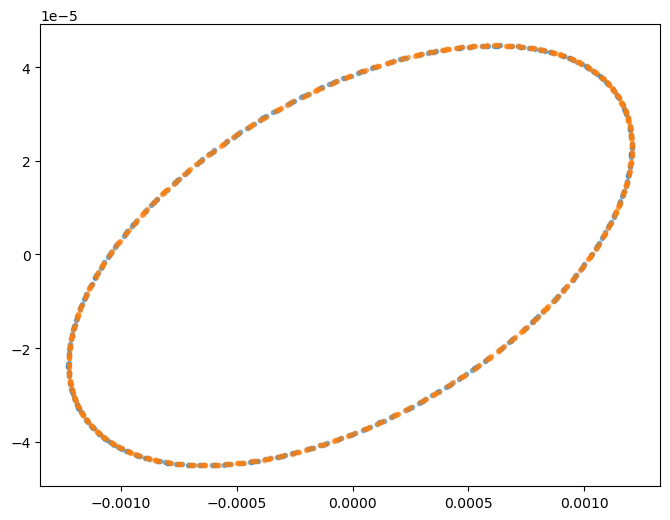

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
pid = 568

delta_ranges = np.linspace(np.min(monitor1.delta), np.max(monitor1.delta), 15)
for i in range(len(delta_ranges)-1):
    # if i % 5 != 0:
    #     continue
    mask = (monitor1.delta[pid, :] >= delta_ranges[i]) & (monitor1.delta[pid, :] < delta_ranges[i+1])
    ax.plot(monitor1.x[pid, :][mask], monitor1.px[pid, :][mask], '.', alpha=0.5)
# mask = monitor1.delta[pid, :] < -0.00115
# ax.plot(monitor1.x[pid, :][mask], monitor1.px[pid, :][mask], '.')

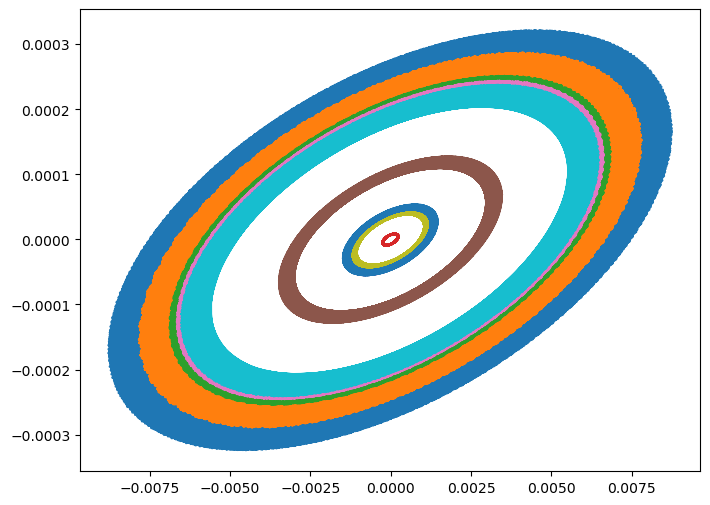

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
pid = 568

for pid in np.linspace(560, 570, 11, dtype=int):
    ax.plot(monitor1.x[pid, :], monitor1.px[pid, :])

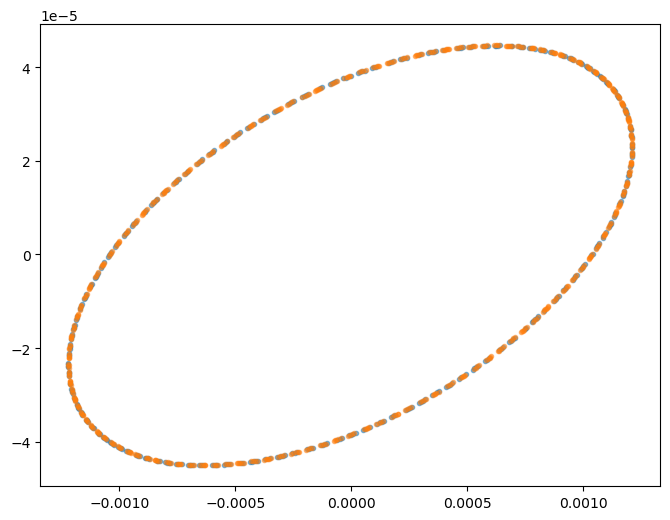

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
pid = 568

delta_ranges = np.linspace(np.min(monitor1.delta), np.max(monitor1.delta), 15)
for i in range(len(delta_ranges)-1):
    # if i % 5 != 0:
    #     continue
    mask = (monitor1.delta[pid, :] >= delta_ranges[i]) & (monitor1.delta[pid, :] < delta_ranges[i+1])
    ax.plot(monitor1.x[pid, :][mask] - tw.rows['monitor_qd31110'].dx[0] * monitor1.delta[pid, :][mask], monitor1.px[pid, :][mask], '.', alpha=0.5)
# mask = monitor1.delta[pid, :] < -0.00115
# ax.plot(monitor1.x[pid, :][mask], monitor1.px[pid, :][mask], '.')

In [81]:
np.max(monitor1.delta[pid, :])

LinkedArrayCpu(0.00116879)

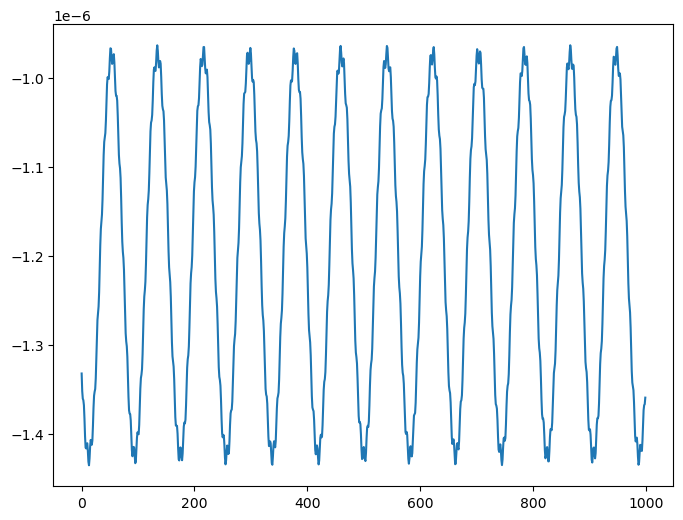

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
turns = np.linspace(0, num_turns-1, num_turns)
ax.plot(turns, monitor1.delta[pid, :], '-')

In [108]:
initial_distributions = {(monitor1.x[pid, 0], monitor1.px[pid, 0]) : [monitor1.x[pid, :], monitor1.px[pid, :]] for pid in range(num_particles)}

In [110]:
import json

In [112]:
with open('initial_distributions_phase_space.json', 'w') as f:
    json.dump({str(k): [v[0].tolist(), v[1].tolist()] for k, v in initial_distributions.items()}, f, indent=4)

# Tracking with initial distribution, without RF-sweep, to see if I get the ellipse

In [117]:
ini_cond = list(initial_distributions.keys())

In [133]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw = line.twiss()

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [134]:
env = line.env
monitor1 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
monitor2 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)

env.elements['monitor_qd31110'] = monitor1
env.elements['monitor_qf31010'] = monitor2
line.insert([env.place('monitor_qd31110', at='qd.31110@end'), env.place('monitor_qf31010', at='qf.31010@end')])

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [135]:
tidp = install_tidp(line, block_mvt=29e-3)
tw = line.twiss()
tt = line.get_table()
line.collimators.assign_optics(nemitt_x=nemitt_x, nemitt_y=nemitt_y)

Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

In [144]:
part = line.build_particles(x=initial_distributions[ini_cond[0]][0], px=initial_distributions[ini_cond[0]][1], 
                            match_at_s=line.get_s_position('monitor_qd31110'), 
                            at_element = line.element_names.index('monitor_qd31110'),
                            mode='normalized_transverse')

In [149]:
part.delta = tw.particle_on_co.delta
part.zeta = tw.particle_on_co.zeta

In [151]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


In [152]:
line.scattering.enable()
line.track(part, num_turns=num_turns, time=True, with_progress=True)
line.scattering.disable()

Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

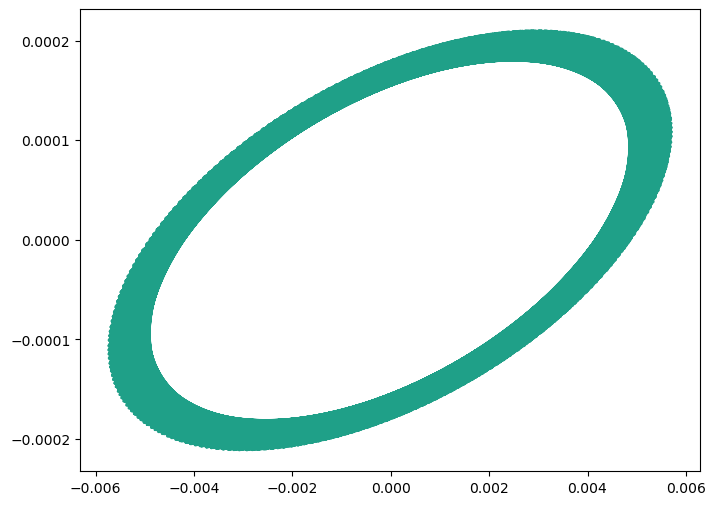

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
pid = 569
# ax.plot(monitor1.x[pid, :], monitor1.px[pid, :])

cmap = colormaps['viridis']
for pid in np.linspace(560, 565, 6, dtype=int):
    ax.plot(monitor1.x[pid, :], monitor1.px[pid, :], color = cmap(pid / num_particles))

The band comes from small couplings between x and y if I remember correctly, it is the same band for each particle I plot, so it seems to do the job...

# Tracking with RF-sweep to see the difference, with delta and zeta on closed orbit values

In [168]:
num_particles = 1000
num_turns = 6000
num_turns_presweep = 1000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
sweep_per_turn = sweep / num_turns
nemitt_x = 2e-6
nemitt_y = 2e-6

In [182]:
# line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
line.particle_ref = xt.Particles.reference_from_pdg_id('proton',p0c=25.92e9)
tt = line.get_table()
tw = line.twiss()

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


ValueError: Invalid one-turn map: No coordinates respond to variations of x

In [170]:
env = line.env
monitor1 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns + num_turns_presweep)
monitor2 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns + num_turns_presweep)

env.elements['monitor_qd31110'] = monitor1
env.elements['monitor_qf31010'] = monitor2
line.insert([env.place('monitor_qd31110', at='qd.31110@end'), env.place('monitor_qf31010', at='qf.31010@end')])

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [171]:
tidp = install_tidp(line, block_mvt=29e-3)
tw = line.twiss()
tt = line.get_table()
line.collimators.assign_optics(nemitt_x=nemitt_x, nemitt_y=nemitt_y)

Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

In [172]:
part = line.build_particles(x=initial_distributions[ini_cond[0]][0], px=initial_distributions[ini_cond[0]][1], 
                            match_at_s=line.get_s_position('monitor_qd31110'), 
                            at_element = line.element_names.index('monitor_qd31110'),
                            mode='normalized_transverse')

part.delta = tw.particle_on_co.delta
part.zeta = tw.particle_on_co.zeta

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.0 turns.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

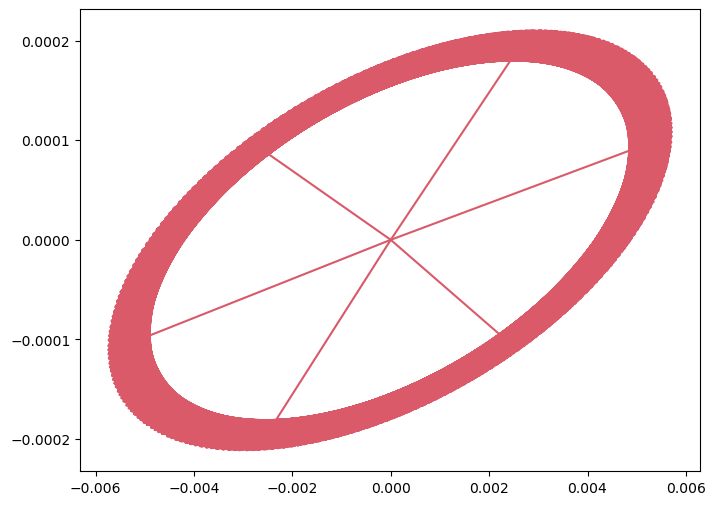

In [173]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

#Track without sweep
line.scattering.enable()
line.track(part, num_turns=num_turns_presweep, time=True, with_progress=True)
line.scattering.disable()

#Check phase space is ok
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cmap = colormaps['plasma']
for pid in np.linspace(560, 565, 6, dtype=int):
    ax.plot(monitor1.x[pid, :], monitor1.px[pid, :], color = cmap(pid / num_particles))

#Track with sweep
rf_sweep = xc.RFSweep(line)
rf_sweep.prepare(sweep_per_turn=sweep/num_turns)
rf_sweep.info()

line.scattering.enable()
line.track(part, num_turns=num_turns, time=True, with_progress=True)
line.scattering.disable()

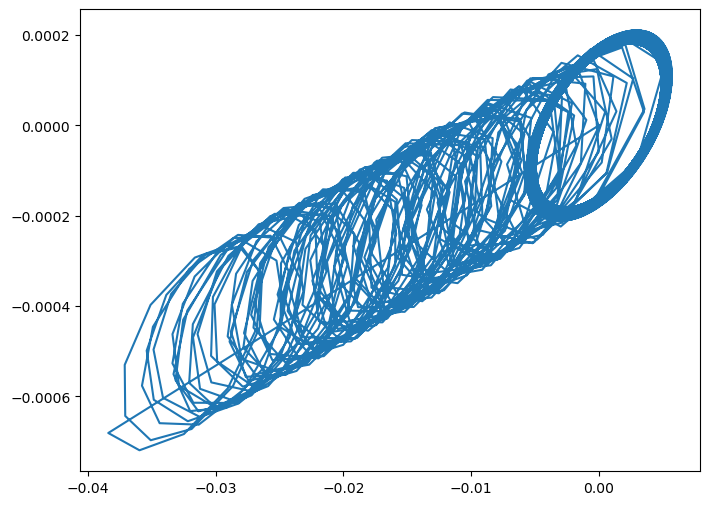

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
pid = 300
cmap = colormaps['viridis']
# for turn in range(num_turns + num_turns_presweep):
#     ax.plot(monitor1.x[pid, :], monitor1.px[pid, :])#, color=cmap(turn / (num_turns + num_turns_presweep)))


ax.plot(monitor1.x[pid, :], monitor1.px[pid, :])

# cmap = colormaps['viridis']
# for pid in np.linspace(560, 565, 6, dtype=int):
#     ax.plot(monitor1.x[pid, :], monitor1.px[pid, :], color = cmap(pid / num_particles))